# CNN for log-mel spectrogram classification
Training and evaluating a convolutional neural network on log-mel spectrograms extracted from ESC-10 audio clips.

The architecture of the cnn and the training procedure are from [Ahmed et al 2020](https://www.researchgate.net/publication/344519283_Automatic_Environmental_Sound_Recognition_AESR_Using_Convolutional_Neural_Network)

Data augmentation is based on [Mushtaq et al 2021](https://www.researchgate.net/publication/343961057_Spectral_images_based_environmental_sound_classification_using_CNN_with_meaningful_data_augmentation)

The dataset is [ESC-10](https://github.com/karolpiczak/ESC-50)

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio
from tqdm.auto import tqdm

import random
import os
import shutil

import librosa
from scipy.io import wavfile

In [3]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(SEED)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Dataset preparation
___

### 1. Data reorganization
Extracting ESC-10 from ESC-50.

In [5]:
data_folder = "Data"

esc50_root = os.path.join(data_folder, "ESC-50")
esc50_audio = os.path.join(esc50_root, "audio")
esc50_meta_folder = os.path.join(esc50_root, "meta")
esc50_metadata = os.path.join(esc50_meta_folder, "esc50.csv")

esc10_root = os.path.join(data_folder, "ESC-10")
esc10_audio = os.path.join(esc10_root, "audio")
esc10_meta_folder = os.path.join(esc10_root, "meta")
esc10_metadata = os.path.join(esc10_meta_folder, "esc10.csv")

In [6]:
esc50 = pd.read_csv(esc50_metadata)
esc10 = esc50.loc[esc50['esc10'] == True].drop(columns=['esc10']).reset_index(drop=True)

In [7]:
if not os.path.exists(esc10_root):
    os.makedirs(esc10_root)

if not os.path.exists(esc10_audio):
    os.makedirs(esc10_audio)

if not os.path.exists(esc10_meta_folder):
    os.makedirs(esc10_meta_folder)

esc10.to_csv(esc10_metadata, index=False, header=True)

for i in range(len(esc10)):
    filepath = os.path.join(esc50_audio, esc10.loc[i, "filename"])
    filepath_new = os.path.join(esc10_audio, esc10.loc[i, "filename"])
    shutil.copyfile(filepath, filepath_new)

### 2. Dataset exploration

In [8]:
SR = 16000

In [9]:
dataset_meta = pd.read_csv(esc10_metadata)
dataset_meta.head()

,filename,fold,target,category,src_file,take
0,1-100032-A-0.wav,1,0,dog,100032,A
1,1-110389-A-0.wav,1,0,dog,110389,A
2,1-116765-A-41.wav,1,41,chainsaw,116765,A
3,1-17150-A-12.wav,1,12,crackling_fire,17150,A
4,1-172649-A-40.wav,1,40,helicopter,172649,A


In [10]:
target_to_label = {0: "dog", 41: "chainsaw", 12: "crackling_fire", 40: "helicopter", 10: "rain",
                   20: "crying_baby", 38: "clock_tick", 21: "sneezing", 1: "rooster", 11: "sea_waves"}
label_to_target = {"dog": 0, "chainsaw": 41, "crackling_fire": 12, "helicopter": 40, "rain": 10,
                   "crying_baby": 20, "clock_tick": 38, "sneezing": 21, "rooster": 1, "sea_waves": 11}
target_to_y = {0: 0, 41:1, 12: 2, 40: 3, 10: 4, 20: 5, 38: 6, 21: 7, 1: 8, 11: 9}
y_to_target = {0: 0, 1:41, 2: 12, 3: 40, 4: 10, 5: 20, 6: 38, 7: 21, 8: 1, 9: 11}

In [11]:
samples = dataset_meta.drop_duplicates("category")["filename"].reset_index(drop=True).to_list()
plot_files = random.sample(samples, k=4)
plot_labels = [dataset_meta[dataset_meta["filename"] == plot_files[i]]["target"].item() for i in range(4)] 
plot_audios = []
for filename in plot_files:
    filename = os.path.join(esc10_audio, filename)
    wav, _ = librosa.load(filename, sr=SR)
    plot_audios.append(wav)

In [12]:
print(f"Sound of {target_to_label[plot_labels[0]]}")
Audio(data=plot_audios[0], rate=SR)

Sound of chainsaw


In [13]:

print(f"Sound of {target_to_label[plot_labels[1]]}")
Audio(data=plot_audios[1], rate=SR)

Sound of dog


In [14]:
print(f"Sound of {target_to_label[plot_labels[2]]}")
Audio(data=plot_audios[2], rate=SR)

Sound of rain


In [15]:

print(f"Sound of {target_to_label[plot_labels[3]]}")
Audio(data=plot_audios[3], rate=SR)

Sound of sea_waves


Text(0.5, 0.98, 'Waveforms')

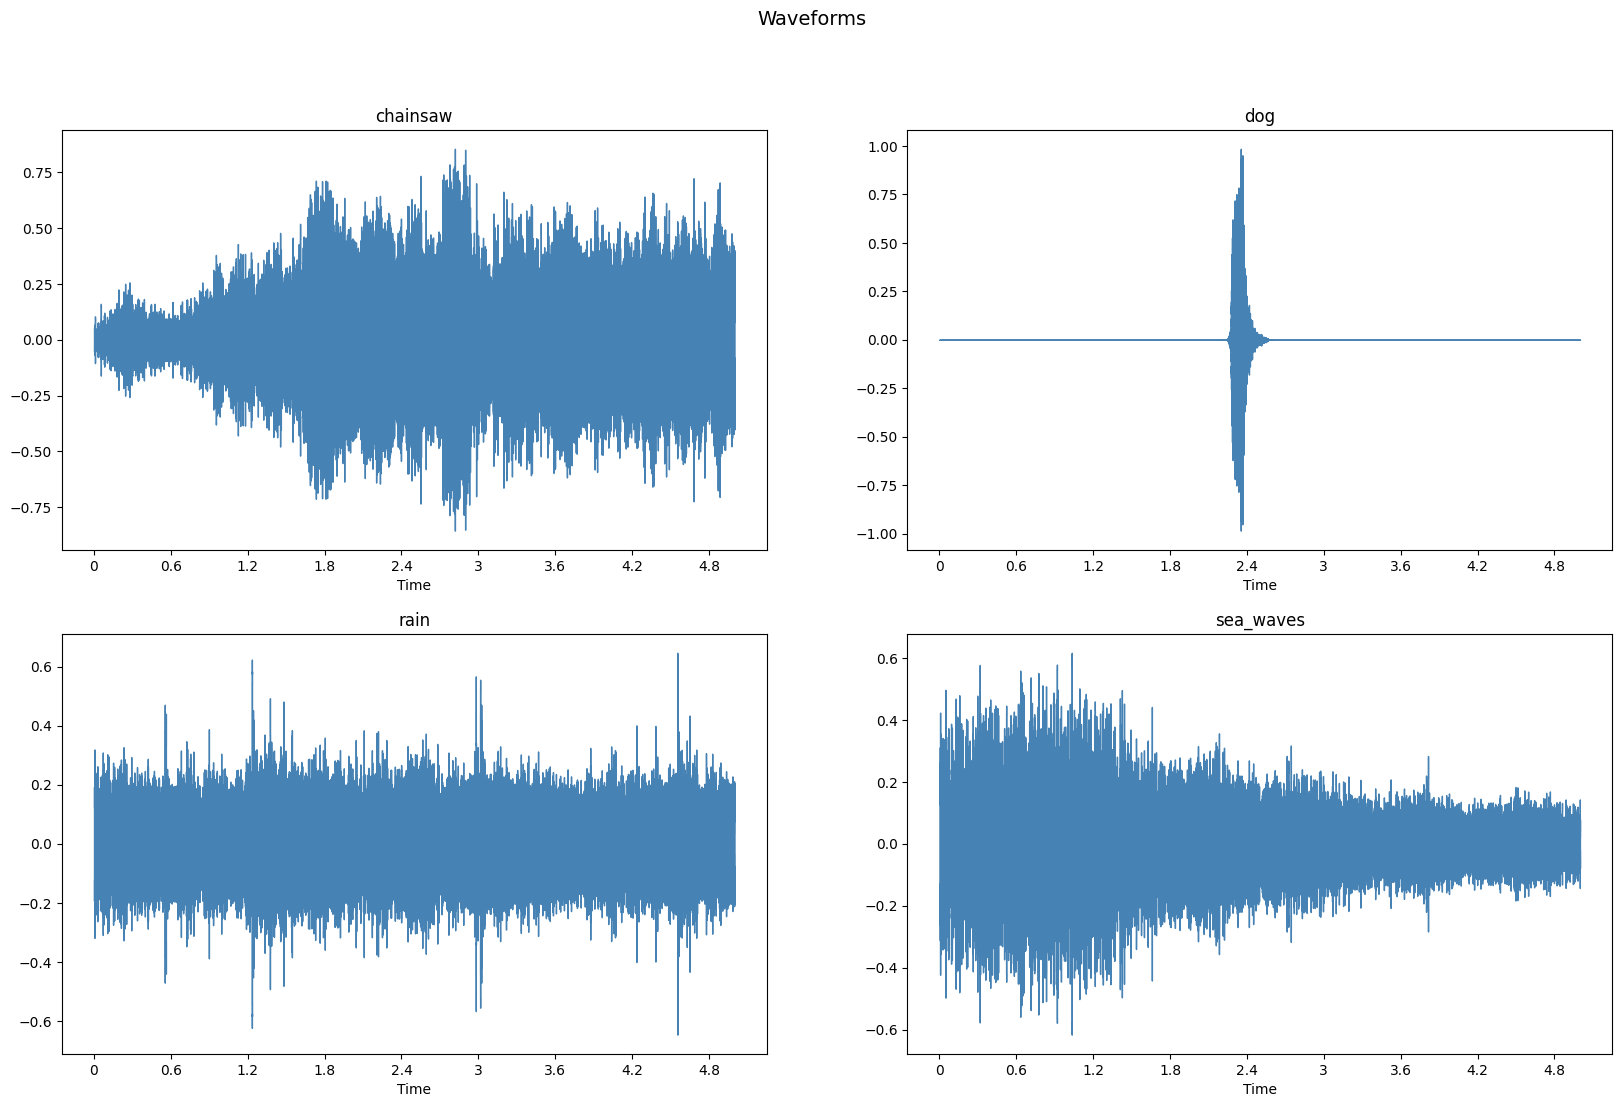

In [16]:
plt.figure(figsize=(20, 12))
for i in range(1, 5):
    plt.subplot(2, 2, i)
    librosa.display.waveshow(plot_audios[i - 1], sr=SR, color="steelblue")
    plt.title(target_to_label[plot_labels[i - 1]])
plt.suptitle("Waveforms", fontsize=14)

Text(0.5, 0.98, 'Mel spectrograms')

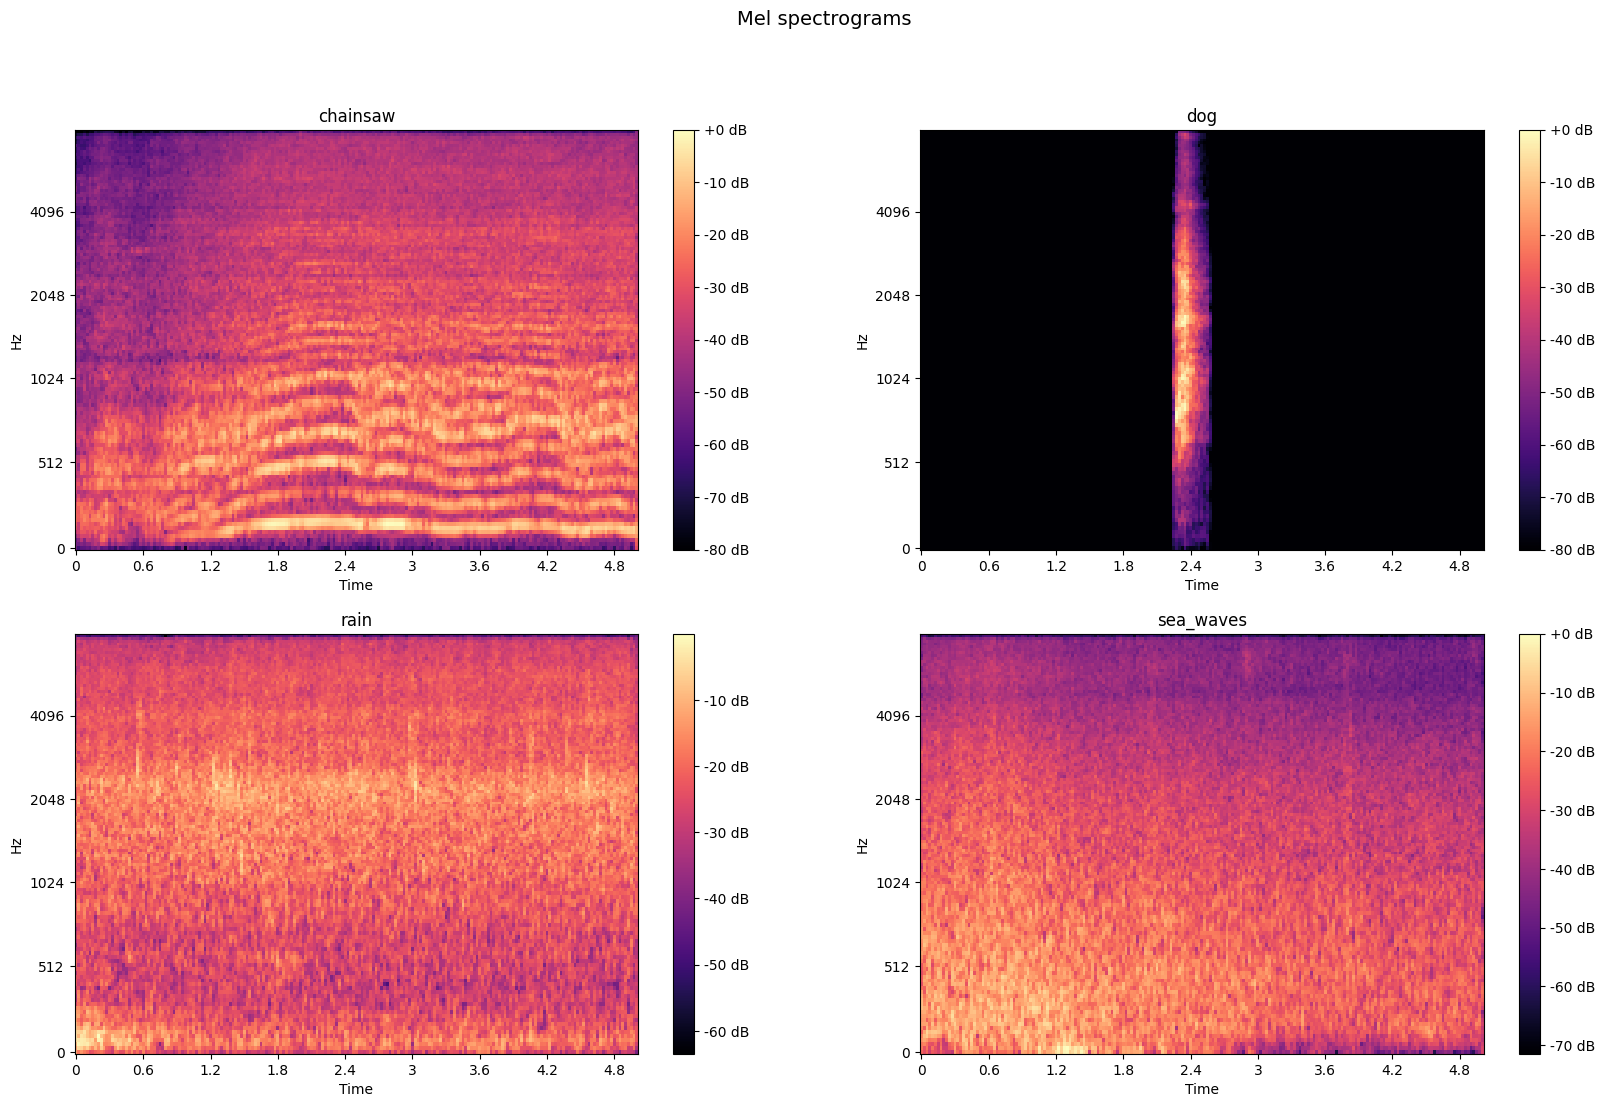

In [17]:
plt.figure(figsize=(20, 12))
for i in range(1, 5):
    plt.subplot(2, 2, i)
    spec = librosa.feature.melspectrogram(y=plot_audios[i - 1], sr=SR, n_fft=1024, win_length=800, hop_length=400)
    spec_db = librosa.power_to_db(spec, ref=np.max)
    librosa.display.specshow(spec_db, sr=SR, x_axis="time", y_axis="mel", hop_length=400, n_fft=1024, win_length=400)
    plt.colorbar(format="%+2.0f dB")
    plt.title(target_to_label[plot_labels[i - 1]])
plt.suptitle("Mel spectrograms", fontsize=14)

### 3. Data augmentation

In [18]:
"""
Methods for augmenting data. Implementations strictly follow the description from Mushtaq et al paper.
"""

augmentations = {"ts", "nps", "pps", "sts", "fts"}

def trim_silence(audio):
    input_length = len(audio)
    audio_trimmed, _ = librosa.effects.trim(audio)

    if len(audio_trimmed) < len(audio):
        offset = input_length - len(audio_trimmed)
        audio_trimmed = np.pad(audio_trimmed, pad_width=(0, offset), mode="constant")

    return audio_trimmed

def negative_pitch_shift(audio):
    audio_aug = librosa.effects.pitch_shift(audio, n_steps=-2, sr=SR)

    return audio_aug

def positive_pitch_shift(audio):
    audio_aug = librosa.effects.pitch_shift(audio, n_steps=2, sr=SR)
    
    return audio_aug

def slow_time_stretch(audio):
    input_length = len(audio)
    audio_aug = librosa.effects.time_stretch(audio, rate=0.7)

    if len(audio_aug) > input_length:
        audio_aug = audio_aug[:input_length]

    return audio_aug

def fast_time_stretch(audio):
    input_length = len(audio)
    audio_aug = librosa.effects.time_stretch(audio, rate=1.2)

    if len(audio_aug) < input_length:
        offset = input_length - len(audio_aug)
        audio_aug = np.pad(audio_aug, pad_width=(0, offset), mode="constant")

    return audio_aug

augmentations = {
    "ts": trim_silence,
    "nps": negative_pitch_shift,
    "pps": positive_pitch_shift,
    "sts": slow_time_stretch,
    "fts": fast_time_stretch
}

In [19]:
"""
Applying augmentations to files and saving them
NOTE: augmented files will be saved as float32-wav
"""

for filename in dataset_meta["filename"]:
    for aug_name, aug in augmentations.items():
        filepath = os.path.join(esc10_audio, filename)
        aug_filename = ("-" + aug_name).join(os.path.splitext(filename))
        aug_filepath = os.path.join(esc10_audio, aug_filename)

        audio, _ = librosa.load(filepath, sr=SR)
        aug_audio = aug(audio)
        wavfile.write(aug_filepath, rate=SR, data=aug_audio)

In [20]:
"""
Updating metadata so that it contains info about augmented files
"""

dataset_meta_upd = dataset_meta.copy()
dataset_meta_upd["augmented"] = False
esc10aug_metadata = os.path.join(esc10_meta_folder, "esc10aug.csv")

for aug in augmentations.keys():
    dataset_aug = dataset_meta.copy()
    dataset_aug["filename"] = dataset_aug["filename"].apply(lambda x: ("-" + aug).join(os.path.splitext(x)))
    dataset_aug["augmented"] = True
    dataset_meta_upd = pd.concat([dataset_meta_upd, dataset_aug]).reset_index(drop=True)

dataset_meta_upd.to_csv(esc10aug_metadata, index=False, header=True)
dataset_meta_upd

,filename,fold,target,category,src_file,take,augmented
0,1-100032-A-0.wav,1,0,dog,100032,A,False
1,1-110389-A-0.wav,1,0,dog,110389,A,False
2,1-116765-A-41.wav,1,41,chainsaw,116765,A,False
3,1-17150-A-12.wav,1,12,crackling_fire,17150,A,False
4,1-172649-A-40.wav,1,40,helicopter,172649,A,False
...,...,...,...,...,...,...,...
2395,5-233160-A-1-fts.wav,5,1,rooster,233160,A,True
2396,5-234879-A-1-fts.wav,5,1,rooster,234879,A,True
2397,5-234879-B-1-fts.wav,5,1,rooster,234879,B,True
2398,5-235671-A-38-fts.wav,5,38,clock_tick,235671,A,True


### 4. Feature extraction

In [21]:
"""
Extracting mel spectrograms, sampling mean and std for normalization.
Since ESC-10 is a small dataset, mean and std will be sampled from the whole dataset.
"""

dataset = dataset_meta_upd.drop(columns=["category", "src_file", "take"])
spectrograms = []

for filename in dataset["filename"]:
    wavpath = os.path.join(esc10_audio, filename)
    waveform, _ = librosa.load(wavpath, sr=SR)
    mel = librosa.feature.melspectrogram(y=waveform, n_fft=1024, win_length=800, hop_length=400)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = librosa.util.fix_length(mel_db, axis=1, size=128)
    spectrograms.append(mel_db)

spectrograms_set = np.array(spectrograms)
esc10_mean = spectrograms_set.mean()
esc10_std = spectrograms_set.std()

In [22]:
esc10_mean, esc10_std

(-46.271446, 21.147043)

In [21]:
dataset["spectrogram"] = spectrograms
dataset

,filename,fold,target,augmented,spectrogram
0,1-100032-A-0.wav,1,0,False,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
1,1-110389-A-0.wav,1,0,False,"[[-32.226727, -19.645435, -24.480835, -30.5033..."
2,1-116765-A-41.wav,1,41,False,"[[-53.963615, -62.567436, -58.307602, -57.5017..."
3,1-17150-A-12.wav,1,12,False,"[[-41.045067, -38.56862, -41.810543, -43.03685..."
4,1-172649-A-40.wav,1,40,False,"[[-19.662426, -12.320859, -13.217135, -5.54993..."
...,...,...,...,...,...
2395,5-233160-A-1-fts.wav,5,1,True,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8..."
2396,5-234879-A-1-fts.wav,5,1,True,"[[-39.566284, -52.101143, -51.318382, -48.5349..."
2397,5-234879-B-1-fts.wav,5,1,True,"[[-56.077667, -49.2386, -45.621243, -52.817368..."
2398,5-235671-A-38-fts.wav,5,38,True,"[[-13.398457, -8.022323, -7.717063, -19.368092..."


### 5. Classes, loaders, useful methods

In [22]:
class ESC10(Dataset):
    def __init__(self, meta, transformation=None):
        self.meta = meta
        self.transformation = transformation

    def __len__(self):
        return len(self.meta)
    
    def __getitem__(self, index):
        spec = torch.from_numpy(self.meta.loc[index, "spectrogram"]).unsqueeze(0)
        if self.transformation is not None:
            spec = self.transformation(spec)
        target = self.meta.loc[index, "target"]

        return spec, target_to_y[target]

In [23]:
"""
ESC-10 is originalky divided into 5 folds. In this implementation, 4 of those folds will be used for training
and the non-augmented data from the remaining fold will be used for testing.
"""

def train_test_split(dataset, test_fold=5):
    train_dataset = dataset[dataset["fold"] != test_fold].reset_index(drop=True)
    train_dataset = train_dataset.drop(columns=["fold", "augmented"])

    test_dataset = dataset[(dataset["fold"] == test_fold) & (dataset["augmented"] == False)].reset_index(drop=True)
    test_dataset = test_dataset.drop(columns=["fold", "augmented"])

    return train_dataset, test_dataset

In [24]:
train_meta, test_meta = train_test_split(dataset)

tf_nrm = lambda x: (x - esc10_mean) / esc10_std

train_data = ESC10(train_meta, transformation=tf_nrm)
test_data = ESC10(test_meta, transformation=tf_nrm)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

## Model building
___

In [25]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.l1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding="valid"),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(p=0.25),
            nn.ReLU()
        )

        self.l2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding="same"),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(p=0.25),
            nn.ReLU()
        )

        self.l3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding="same"),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(p=0.25),
            nn.ReLU()
        )

        self.l4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding="same"),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(p=0.25),
            nn.ReLU()
        )

        self.l5 = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=128 * 7 * 7, out_features=512),
            nn.ReLU()
        )

        self.l6 = nn.Sequential(
            nn.Dropout(p=0.6),
            nn.Linear(in_features=512, out_features=10)
        )
    
        self.sf = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.l1(input_data)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)

        logits = self.l6(x)
        probs = self.sf(logits)

        return logits, probs

In [26]:
cnn = CNN().to(device)
summary(cnn, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             160
         MaxPool2d-2           [-1, 16, 63, 63]               0
           Dropout-3           [-1, 16, 63, 63]               0
              ReLU-4           [-1, 16, 63, 63]               0
            Conv2d-5           [-1, 32, 63, 63]           4,640
         MaxPool2d-6           [-1, 32, 31, 31]               0
           Dropout-7           [-1, 32, 31, 31]               0
              ReLU-8           [-1, 32, 31, 31]               0
            Conv2d-9           [-1, 64, 31, 31]          18,496
        MaxPool2d-10           [-1, 64, 15, 15]               0
          Dropout-11           [-1, 64, 15, 15]               0
             ReLU-12           [-1, 64, 15, 15]               0
           Conv2d-13          [-1, 128, 15, 15]          73,856
        MaxPool2d-14            [-1, 12

## Training & evaluation
___

In [27]:
def train(model, train_loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0
    num_correct_pred = 0

    for X, y_true in train_loader:
        optimizer.zero_grad()
        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, y_probs = model(X)

        loss = loss_fn(y_hat, y_true)

        pred_labels = torch.argmax(y_probs, 1)
        num_correct_pred += (pred_labels == y_true).sum()

        running_loss += loss.item() * X.size(0)

        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = num_correct_pred / len(train_loader.dataset)
    return model, optimizer, epoch_loss, epoch_accuracy

In [28]:
def test(model, test_loader, loss_fn, device):
    model.eval()
    running_loss = 0
    num_correct_pred = 0

    for X, y_true in test_loader:
        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, y_probs = model(X)

        loss = loss_fn(y_hat, y_true)

        pred_labels = torch.argmax(y_probs, 1)
        num_correct_pred += (pred_labels == y_true).sum()

        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_accuracy = num_correct_pred / len(test_loader.dataset)
    return model, epoch_loss, epoch_accuracy

In [29]:
def training_loop(model, train_loader, test_loader, loss_fn, optimizer, n_epochs, checkpoint_path, device):

    train_losses = []
    test_losses = []

    best_accuracy = 0

    for epoch in tqdm(range(n_epochs), desc='Epoch'):
        model, optimizer, train_loss, train_accuracy = train(model, train_loader, loss_fn, optimizer, device)
        train_losses.append(train_loss)

        with torch.no_grad():
            model, test_loss, test_accuracy = test(model, test_loader, loss_fn, device)
            test_losses.append(test_loss)

        print(f'Epoch: {epoch + 1} Train loss:{train_loss:.4f} Test loss:{test_loss:.4f} Train accuracy:{train_accuracy * 100:.2f}% Test accuracy:{test_accuracy * 100:.2f}%')

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': test_loss,
            },
            checkpoint_path
            )

    return model, train_losses, test_losses

In [30]:
weights_folder = "Weights"

if not os.path.exists(weights_folder):
    os.makedirs(weights_folder)
    
checkpoint_path = os.path.join(weights_folder, "cnn_best.pth")

In [31]:
cnn = CNN().to(device)
n_epochs = 400
optimizer = optim.Adam(cnn.parameters())
loss_fn = nn.CrossEntropyLoss()

In [32]:
cnn, train_losses, test_losses = training_loop(
    cnn, train_loader, test_loader, loss_fn, optimizer, n_epochs, checkpoint_path, device
)

Epoch:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 1 Train loss:1.7672 Test loss:1.4315 Train accuracy:32.45% Test accuracy:47.50%
Epoch: 2 Train loss:1.0947 Test loss:1.0832 Train accuracy:59.01% Test accuracy:56.25%
Epoch: 3 Train loss:0.7633 Test loss:0.9155 Train accuracy:71.72% Test accuracy:78.75%
Epoch: 4 Train loss:0.5788 Test loss:0.8265 Train accuracy:79.64% Test accuracy:73.75%
Epoch: 5 Train loss:0.4571 Test loss:0.9739 Train accuracy:83.33% Test accuracy:77.50%
Epoch: 6 Train loss:0.4092 Test loss:0.8695 Train accuracy:84.95% Test accuracy:81.25%
Epoch: 7 Train loss:0.3175 Test loss:1.1570 Train accuracy:88.02% Test accuracy:78.75%
Epoch: 8 Train loss:0.3257 Test loss:1.0876 Train accuracy:88.49% Test accuracy:78.75%
Epoch: 9 Train loss:0.2989 Test loss:0.9772 Train accuracy:89.74% Test accuracy:76.25%
Epoch: 10 Train loss:0.2001 Test loss:0.9714 Train accuracy:93.39% Test accuracy:81.25%
Epoch: 11 Train loss:0.1836 Test loss:0.9384 Train accuracy:93.23% Test accuracy:83.75%
Epoch: 12 Train loss:0.1960 Test loss:1.1

In [33]:
cnn.load_state_dict(torch.load(checkpoint_path)['model_state_dict'])
cnn, test_loss, test_accuracy = test(
    cnn, test_loader, loss_fn, device
)
print(f'Test loss:{test_loss:.4f} Test accuracy:{test_accuracy * 100:.2f}%')

Test loss:1.4206 Test accuracy:86.25%
